In [1]:
import pandas as pd
import numpy as np
import lfp.lfp_analysis.LFP_collection as LFP_collection
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
import lfp.lfp_analysis.plotting as lfplt
from itertools import combinations, permutations
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from lfp.lfp_analysis.LFP_collection import LFPCollection
from lfp.lfp_analysis.LFP_recording import LFPRecording
from importlib import reload
from scipy.signal import find_peaks
from sklearn.decomposition import NMF
def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl
    Returns:
        none
    """
    with open(file_name, "wb") as file:
        pickle.dump(thing_to_pickle, file)


def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, "rb") as file:
        return pickle.load(file)

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

object_control_lfp_json = r"C:\Users\megha\UFL Dropbox\Meghan Cum\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Object_Control (phase 7)\lfp_data\lfp_collection.json"

object_collection = LFP_collection.LFPCollection.load_collection(object_control_lfp_json)


target_dict = {'1.1': [],
              '1.2': [],
              '1.3': [],
              '2.1': [],
              '2.2': ['vHPC'],
              '2.3': ['mPFC'],
              '2.4': ['MD'],
              '3.1': [],
              '3.2': [],
              '3.3': ['MD'],
              '4.1': [],
              '4.4': ['NAc']}

object_collection.exclude_regions(target_dict)
object_collection.interpolate()

behavior_dicts = unpickle_this('pilot2/object_control/object_behavior_dicts.pkl')

    
for recording, behavior_dict in behavior_dicts.items():
    filename = recording.split('_')[0]
    for recording in object_collection.recordings:
        if recording.name.split('_')[0] == filename:
            recording.set_event_dict(behavior_dict)

In [69]:
# COLUMNS (SAMPLES) X ROWS (FEATURES) MATRIX

# samples = average sniffs at all times points same way i make a pca plot ...  
# features are all granger and power and coherences across all freq 
import lfp.lfp_analysis.event_extraction as ee
from importlib import reload
reload(ee)
events = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse']
all_events = []
for recording in object_collection.recordings:
    rec_events = []
    for event in events:
        is_first = True
        for mode in ['power', 'coherence', 'granger']:
            rec_data = ee.get_events(recording, event,
                                        mode = mode,
                                        event_len = 5,
                                        pre_window = 1,
                                        post_window = 0,
                                        average = False)
            
            #rec_shape = [e,t,f,b,b]
            rec_average = np.nanmean(np.array(rec_data)[:,:,0:100,...], axis = 0)
            #rec_shape = [t,f,b]
            rec_data_2d = rec_average.reshape(rec_average.shape[0], -1)
            if is_first:
                rec_all_data = rec_data_2d 
                is_first = False
            if not is_first:
                rec_all_data = np.concatenate((rec_all_data, rec_data_2d), axis = 1)
        rec_events.append(rec_all_data)
    rec_events = np.vstack(rec_events)
    all_events.append(rec_events)
all_events = np.mean(np.array(all_events), axis = 0)



        
print(all_events.shape)    
X = all_events

(48, 6000)


In [70]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_



c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [71]:
print(W.shape)

(48, 2)


NameError: name 'H' is not defined

In [72]:
events = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse']

In [73]:
nmf_key = [events[0]]* 12 + [events[1]] * 12 + [events[2]] * 12 + [events[3]] * 12
nmf_matrix = W
event_length = 5
pre_window = 1

In [85]:
def NMF_EDA_plot(lfp_collection, nmf_matrix, nmf_key, event_length, pre_window, post_window, min_events):
    """
    Plots nmf trajectories calculated in nmf_trajectories using the same
    pre window, post window, and event_length parameters. Each event type is
    a different color. Preevent start is signified by a square, onset of behavior
    signified by a triangle, and the end of the event is signified by a circle.
    If post-event time is included that end of post event time is signified by a diamond.

    Plots individual trial nmf trajectories with each event type in a different color.
    All trials for the same event share the same color with transparency.

    Args:
        lfp_collection:lfpeCollection object containing recording data
        nmf_matrix: Matrix of nmf transformed data
        nmf_key: List of event labels for each point
        event_length: Length of event in seconds
        pre_window: Time before event in seconds
        post_window: Time after event in seconds
        alpha: Transparency level for trial trajectories (default=0.3)
        marker_size: Size of trajectory points (default=3)
        highlight_markers: Whether to show event markers (default=True)
    """
    conv_factor = lfp_collection.recordings[0].timestep
    timebins_per_trial = int((event_length + pre_window + post_window) / conv_factor)
    event_end = int((event_length + pre_window) * conv_factor)
    pre_window = pre_window * conv_factor
    post_window = post_window * conv_factor
    alpha = 0.5
    marker_size = 5
    highlight_markers = True
    # Get unique events and assign colors
    unique_events = list(set(nmf_key))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_events)))
    color_dict = dict(zip(unique_events, colors))
    # Plot each trial
    for i in range(0, len(nmf_key), timebins_per_trial):
        event_label = nmf_key[i]
        color = color_dict[event_label]

        # Calculate marker positions for this trial
        onset = int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + timebins_per_trial - 1)

        # Plot trajectory
        plt.plot(
            nmf_matrix[i : i + timebins_per_trial, 0],
            nmf_matrix[i : i + timebins_per_trial, 1],
            color=color,
            alpha=alpha,
            linewidth=0.5,
        )

        plt.scatter(
            nmf_matrix[i : i + timebins_per_trial, 0],
            nmf_matrix[i : i + timebins_per_trial, 1],
            s=marker_size,
            color=color,
            alpha=alpha,
        )

        # Add event markers if requested
        if highlight_markers:
            marker_kwargs = dict(s=30, alpha=1, edgecolors=color, facecolors="none")

            # Start marker
            if pre_window != 0:
                plt.scatter(nmf_matrix[i, 0], nmf_matrix[i, 1], marker="s", color = color, **marker_kwargs)

            # Event onset marker
            plt.scatter(nmf_matrix[onset, 0], nmf_matrix[onset, 1], marker="^", color = color, **marker_kwargs)

            # Event end marker
            plt.scatter(nmf_matrix[end, 0], nmf_matrix[end, 1], marker="o", color= color, **marker_kwargs)

            # Post-event marker if applicable
            if post_window != 0:
                plt.scatter(nmf_matrix[post, 0], nmf_matrix[post, 1], marker="D", color=color, **marker_kwargs)

    # Add legend with one entry per event type
    handles = [
        plt.Line2D([0], [0], color=color_dict[event], label=event, alpha=0.8, marker="o", markersize=5)
        for event in unique_events
    ]
    plt.legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1))

    # Set title based on whether post-window exists
    post_win_text = ""
    pre_win_text = ""
    if post_window != 0:
        post_win_text = ", Post = ◇"
    if pre_window != 0:
        pre_win_text = "Pre-event = □, "
    title = pre_win_text + "Onset = △, End = ○" + post_win_text
    plt.title(title)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

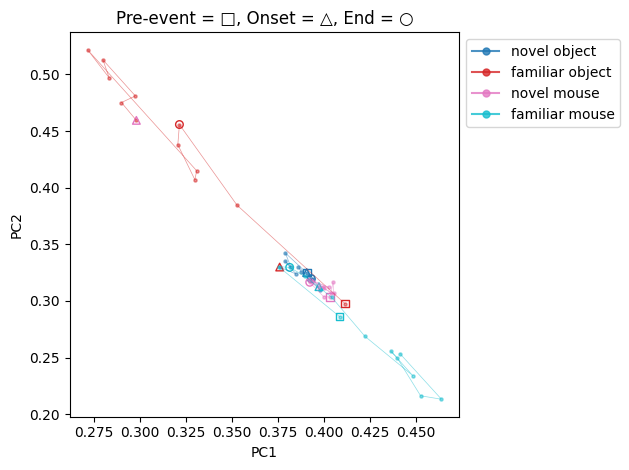

In [86]:
NMF_EDA_plot(object_collection, nmf_matrix, nmf_key, event_length, pre_window,0,0)